In [51]:
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load the data
with open("../datasets/ground_truth.json", "r") as f:
    data = json.load(f)


# Extract turning points and arc labels
x_ds = []
y_ds = []
narrative_ids = []

for narrative in data:
    # Get synopsis length
    synopsis_length = len(narrative.get('synopsis', ''))
    
    # Get turning points and normalize by synopsis length
    tps = [
        narrative['turning_points'].get("tp1", 0) / synopsis_length,
        narrative['turning_points'].get("tp2", 0) / synopsis_length,
        narrative['turning_points'].get("tp3", 0) / synopsis_length,
        narrative['turning_points'].get("tp4", 0) / synopsis_length,
        narrative['turning_points'].get("tp5", 0) / synopsis_length
    ]
    
    # Add synopsis length and arc label to features
    tps.append(synopsis_length)
    tps.append(narrative.get("arc_label", "Unknown"))
    x_ds.append(tps)
    
    # Get source label
    y_ds.append(narrative.get("source", "Unknown"))  # Handle unknown sources if any
    
    # Get narrative ID
    narrative_ids.append(narrative.get("narrative_id", "Unknown"))


# Convert to pandas DataFrame for easier manipulation
df = pd.DataFrame(x_ds, columns=['tp1', 'tp2', 'tp3', 'tp4', 'tp5', 'synopsis_length', 'arc_label'])
df['source'] = y_ds
df['narrative_id'] = narrative_ids

In [52]:
df
# Load arousal scores
with open("arousal_binned.pkl", "rb") as f:
    arousal_scores = pd.read_pickle(f)

# Merge dataframes on narrative_id
df = df.merge(arousal_scores, on='narrative_id', how='left')

df


,tp1,tp2,tp3,tp4,tp5,synopsis_length,arc_label,source,narrative_id,arousal_bin_0,...,arousal_bin_30,arousal_bin_31,arousal_bin_32,arousal_bin_33,arousal_bin_34,arousal_bin_35,arousal_bin_36,arousal_bin_37,arousal_bin_38,arousal_bin_39
0,0.150000,0.233333,0.550000,0.533333,0.716667,30,Man in a Hole,GPT,54868396,0.370,...,0.33,0.00,0.550,0.46,0.65,0.00,0.37,0.400,0.380,0.00
1,0.114754,0.180328,0.598361,0.475410,0.868852,61,Riches to Rags,Human,66494833,0.595,...,0.61,0.41,0.625,0.68,0.61,0.61,0.58,0.640,0.765,0.72
2,0.048780,0.390244,0.609756,0.731707,0.804878,41,Rags to Riches,GPT,31643609,0.540,...,0.55,0.49,0.560,0.38,0.80,0.64,0.38,0.260,0.480,0.46
3,0.200000,0.285714,0.400000,0.885714,1.000000,35,Man in a Hole,Human,71399138,0.570,...,0.61,0.00,0.360,0.81,0.90,0.84,0.59,0.790,0.420,0.00
4,0.119048,0.190476,0.404762,0.595238,0.809524,42,Cinderella,GPT,92861580,0.295,...,0.48,0.35,0.590,0.46,0.40,0.36,0.56,0.450,0.260,0.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,0.125000,0.325000,0.475000,0.450000,0.625000,40,Rags to Riches,GPT,51944553,0.000,...,0.63,0.56,0.565,0.46,0.00,0.42,0.56,0.465,0.550,0.00
435,0.108108,0.216216,0.297297,0.459459,0.756757,37,Man in a Hole,GPT,19348137,0.000,...,0.55,0.42,0.390,0.32,0.36,0.32,0.43,0.320,0.320,0.00
436,0.095238,0.166667,0.452381,0.452381,0.785714,42,Riches to Rags,Human,52371,0.000,...,0.56,0.36,0.370,0.56,0.47,0.36,0.23,0.480,0.450,0.60
437,0.037037,0.148148,0.342593,0.407407,0.592593,54,Man in a Hole,GPT,50214300,0.220,...,0.65,0.64,0.450,0.49,0.58,0.30,0.48,0.435,0.310,0.50


Training samples: 351
Testing samples: 88
Using device: mps
MLPClassifier(
  (network): Sequential(
    (0): Linear(in_features=46, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)
Epoch [1/100] Train Loss: 0.6885 | Train Acc: 0.5214 Test Loss: 0.6214 | Test Acc: 0.7273
Epoch [2/100] Train Loss: 0.6023 | Train Acc: 0.7179 Test Loss: 0.5412 | Test Acc: 0.7955
Epoch [3/100] Train Loss: 0.5177 | Train Acc: 0.7664 Test Loss: 0.4650 | Test Acc: 0.7841
Epoch [4/100] Train Loss: 0.4587 | Train Acc: 0.7635 Test Loss: 0.4413 | Test Acc: 0.7955
Epoch [5/100] Train Loss: 0.4162 | Train Acc: 0.7892 Test Loss: 0.4408 | Test Acc: 0.8182
Epoch [6/100] Train Loss: 0.3659 | Train Acc: 0.8376 Test Loss: 0.4671 | Test Acc: 0.7727
Epoch [7/100] Train Loss: 0.3389 | Train Acc: 0.8746 Test Los

/var/folders/zm/rm3b7n314q5fgfng3s6k4txc0000gn/T/ipykernel_62028/362345496.py:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model

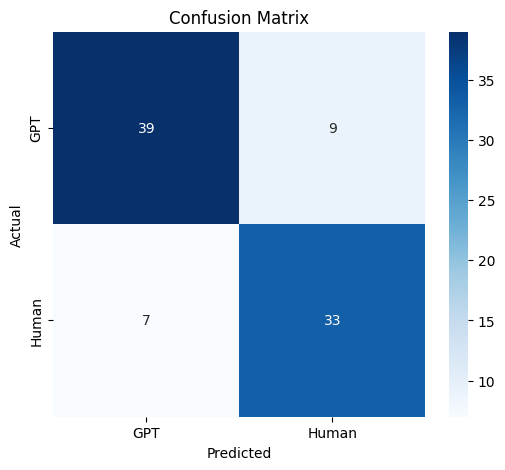

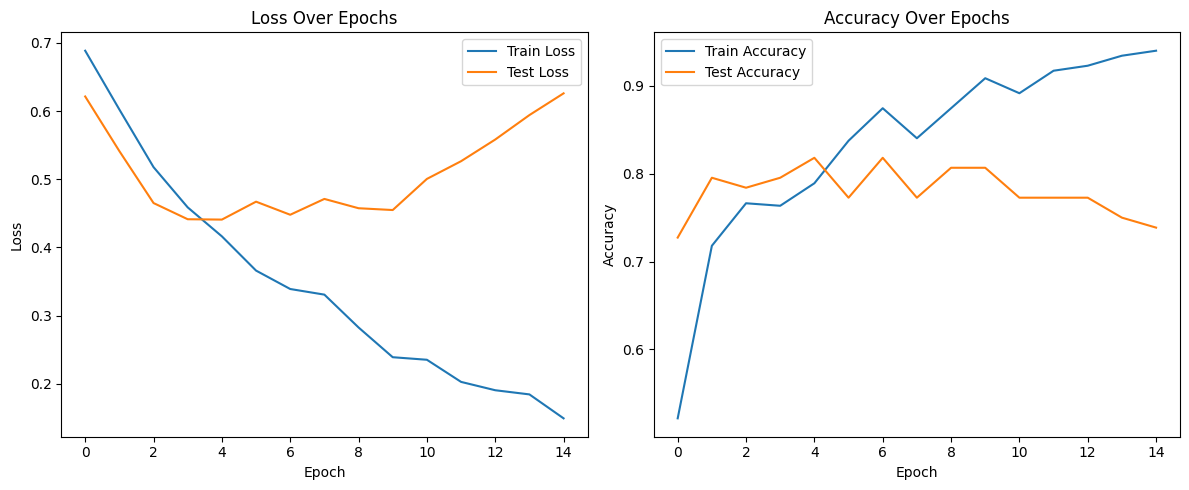

In [57]:
# Handle 'Unknown' sources if present
df = df[df['source'] != 'Unknown']

# Encode the 'source' labels to numerical values
le_source = LabelEncoder()
df['source_encoded'] = le_source.fit_transform(df['source'])

# Encode the arc labels
le_arc = LabelEncoder()
df['arc_label_encoded'] = le_arc.fit_transform(df['arc_label'])

# Features and labels
features = ['tp1', 'tp2', 'tp3', 'tp4', 'tp5', 'arc_label_encoded'] + [col for col in df.columns if col.startswith('arousal_bin_')]
X = df[features].values
y = df['source_encoded'].values

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # For classification
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

# Define the MLP Model
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout=0.5):
        super(MLPClassifier, self).__init__()
        layers = []
        previous_size = input_size
        
        # Create hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(previous_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            previous_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(previous_size, num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Check for device availability
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Define model parameters
input_size = X_train.shape[1]  # Now 7 (5 TPs + synopsis length + arc label)
hidden_sizes = [256, 128]  # Changed based on file context
num_classes = len(le_source.classes_)  # 2
dropout = 0.3  # Changed based on file context

# Instantiate the model, move to device
model = MLPClassifier(input_size, hidden_sizes, num_classes, dropout).to(device)
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Learning rate from file context

# Training parameters
num_epochs = 100
patience = 10  # For early stopping
best_loss = np.inf
counter = 0

# Lists to store loss and accuracy
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    # Evaluation on test set
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    epoch_test_loss = test_loss / len(test_dataset)
    epoch_test_acc = correct_test / total_test
    test_losses.append(epoch_test_loss)
    test_accuracies.append(epoch_test_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} "
          f"Test Loss: {epoch_test_loss:.4f} | Test Acc: {epoch_test_acc:.4f}")
    
    # Early Stopping
    if epoch_test_loss < best_loss:
        best_loss = epoch_test_loss
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

# Final Evaluation on Test Set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=le_source.classes_))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_source.classes_, yticklabels=le_source.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Plot Loss
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Training samples: 351
Testing samples: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2413
[LightGBM] [Info] Number of data points in the train set: 315, number of used features: 46
[LightGBM] [Info] Start training from score -0.616774
[LightGBM] [Info] Start training from score -0.775839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

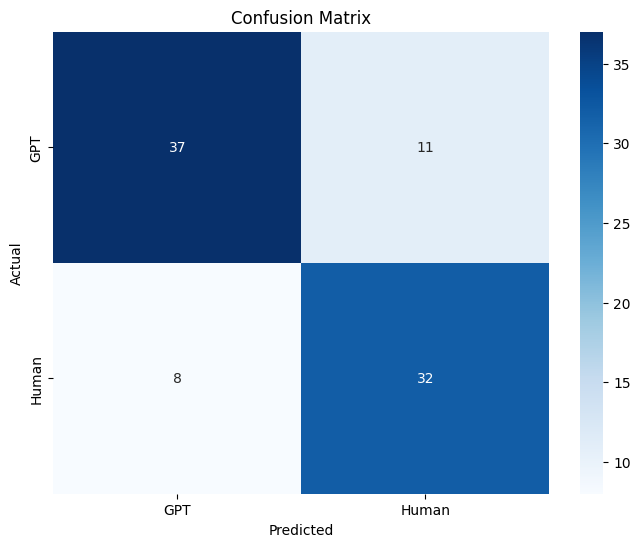

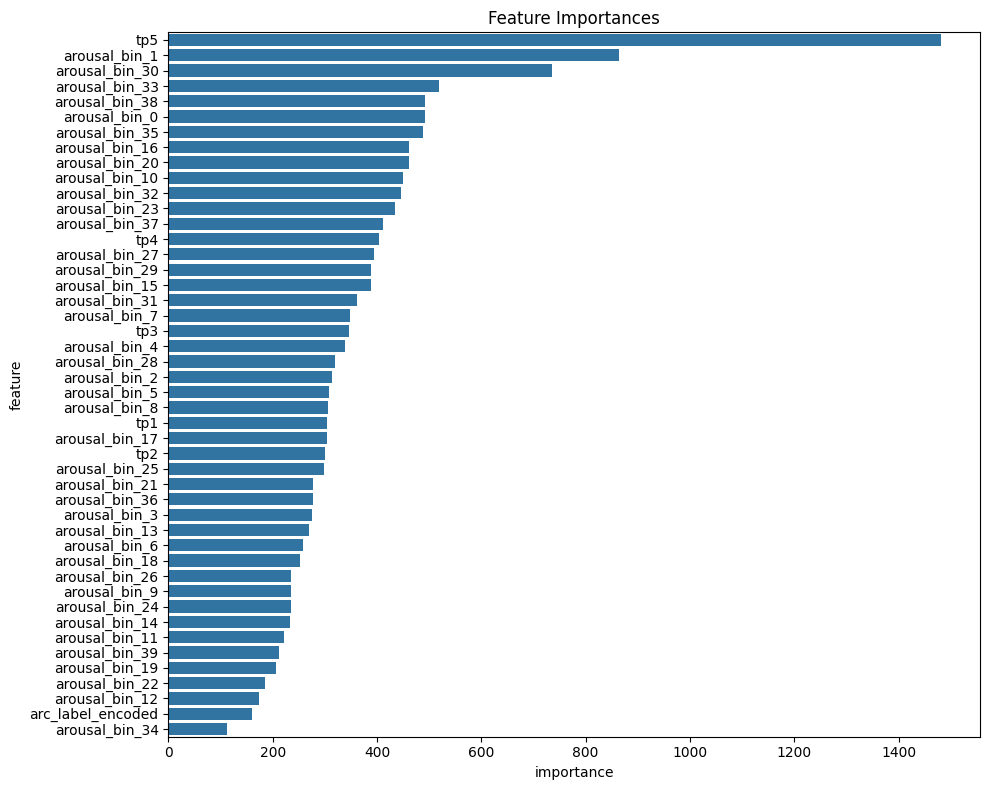

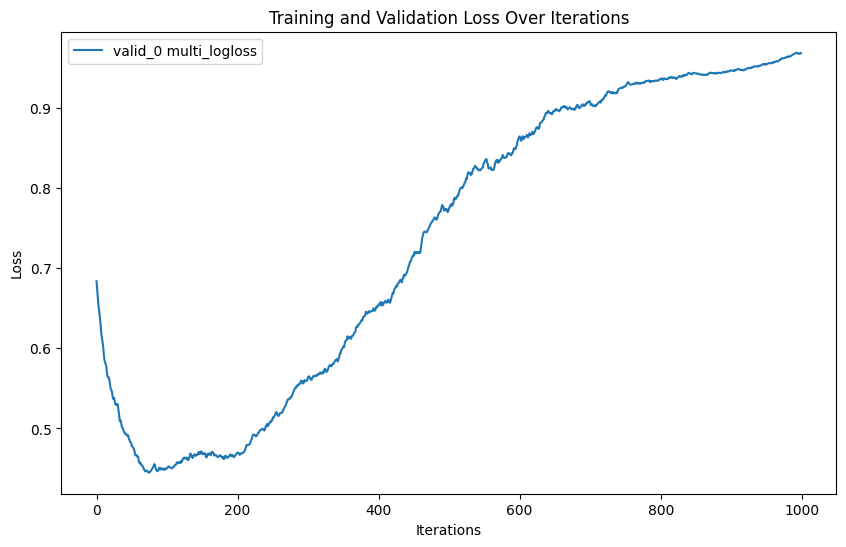

In [63]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb  # LightGBM for boosting
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Load your dataset
# df = pd.read_csv('your_dataset.csv')  # Replace with your data loading method

# For demonstration, let's assume df is already loaded
# Handle 'Unknown' sources if present
df = df[df['source'] != 'Unknown']

# Encode the 'source' labels to numerical values
le_source = LabelEncoder()
df['source_encoded'] = le_source.fit_transform(df['source'])

# Encode the arc labels
le_arc = LabelEncoder()
df['arc_label_encoded'] = le_arc.fit_transform(df['arc_label'])

# Features and labels
feature_cols = [
    'tp1', 'tp2', 'tp3', 'tp4', 'tp5',
    'arc_label_encoded'
] + [col for col in df.columns if col.startswith('arousal_bin_')]
X = df[feature_cols]
y = df['source_encoded']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# Define the LightGBM classifier with basic hyperparameters
lgbm_clf = lgb.LGBMClassifier(
    objective='multiclass',  # Assuming more than two classes; use 'binary' for two
    num_class=len(le_source.classes_),  # Number of classes
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.05,
    n_estimators=1000,
    subsample_for_bin=200000,
    class_weight=None,
    random_state=42,
    n_jobs=-1
)

# Train the model with early stopping
# Create a validation set from the training data
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

# Fit the model
lgbm_clf.fit(
    X_train_final,
    y_train_final,
    eval_set=[(X_val, y_val)],
    eval_metric='multi_logloss'
)

# Predict on the test set
y_pred = lgbm_clf.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_source.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_source.classes_, yticklabels=le_source.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance
importances = lgbm_clf.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

# Optional: Plotting Training and Validation Loss
# LightGBM stores evaluation results in the 'evals_result_' attribute
evals_result = lgbm_clf.evals_result_

plt.figure(figsize=(10, 6))
for dataset in evals_result:
    for metric in evals_result[dataset]:
        plt.plot(
            evals_result[dataset][metric],
            label=f"{dataset} {metric}"
        )
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Iterations')
plt.legend()
plt.show()